In [1]:
import time
import math
from tqdm.auto import tqdm
from tqdm.utils import _term_move_up

prefix = _term_move_up() + '\r'

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from data import DrawingDataset
from customModel import customModel, EarlyStopper

%load_ext autoreload
%autoreload 2

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_properties(0))

True
NVIDIA GeForce RTX 3050 Ti Laptop GPU
_CudaDeviceProperties(name='NVIDIA GeForce RTX 3050 Ti Laptop GPU', major=8, minor=6, total_memory=4095MB, multi_processor_count=20)


In [3]:
batch_size = 256
max_length = 100

train_dataset = DrawingDataset(data_path="./data", split="train", max_length=max_length)
val_dataset = DrawingDataset(data_path="./data", split="valid", max_length=max_length)
test_dataset = DrawingDataset(data_path="./data", split="test", max_length=max_length)

train = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

['./data/cat.npz', './data/sailboat.npz', './data/marker.npz', './data/headphones.npz', './data/airplane.npz']


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


['./data/cat.npz', './data/sailboat.npz', './data/marker.npz', './data/headphones.npz', './data/airplane.npz']


100%|██████████| 5/5 [00:00<00:00, 38.64it/s]


['./data/cat.npz', './data/sailboat.npz', './data/marker.npz', './data/headphones.npz', './data/airplane.npz']


100%|██████████| 5/5 [00:00<00:00, 36.61it/s]


In [4]:
log_interval = 25
epochs = 20

batches = len(train)

model = customModel(nb=4, no=2, ns=2, embed_dim=128).to("cuda")

offset_crit = nn.MSELoss(reduction='none')
state_crit = nn.CrossEntropyLoss()

#optimizer = torch.optim.RAdam(model.parameters(), lr=5e-4)
#warmup_ratio = 0.03s

print(0.05 * math.sqrt(batch_size / (batches * epochs)))
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr=1e-3, betas=(0.99, 0.95), eps=1e-4,
                              weight_decay=0.05 * math.sqrt(batch_size / (batches * epochs)))   
# scheduler = get_cosine_schedule_with_warmup(optimizer, 
#                                             num_warmup_steps=1,
#                                             num_training_steps=epochs)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, 
                                                       T_max=epochs, eta_min=1e-5)

writer = SummaryWriter('./logs/embed_128')

def train_model(model, data_loader, optimizer, epoch):
    model.train()
    
    size = len(data_loader)
    
    # Total Losses
    total_loss = 0
    total_offset_loss = 0
    total_state_loss = 0
    
    # Running Losses
    running_loss = 0
    running_offset_loss = 0
    running_state_loss = 0
    
    running_correct = 0
    running_total = 0
    
    running_mse = 0
    
    start_time = time.time()
    
    for i, data in enumerate(tqdm(data_loader)):
        optimizer.zero_grad()
        
        inputs, targets = data
        inputs = inputs.to("cuda")
        targets = targets.to("cuda")
        
        offsets, states = model(inputs)
        
        # Split Target
        offset_target = targets[:, :, :2]
        state_target = targets[:, :, 2:].argmax(dim=-1)
        no_pad_mask = state_target != 2
        
        # Masked MSE Loss for offset
        offset_loss = offset_crit(offsets, offset_target)
        offset_loss_mask = offset_loss * no_pad_mask.unsqueeze(-1).float()
        
        offset_loss = offset_loss_mask.sum() / no_pad_mask.sum()
        
        # Cross Entropy Loss for State
        state_loss = state_crit(states.transpose(1, 2), state_target)
        loss = offset_loss + state_loss
        
        # Calculate other metrics (accuracy)
        with torch.no_grad():
            states_softmax = torch.nn.functional.softmax(states, dim=-1)
            states_pred = states_softmax.argmax(dim=-1)
            
            no_pad_mask = state_target.flatten() != 2

            running_correct += (states_pred.flatten()[no_pad_mask] == state_target.flatten()[no_pad_mask]).sum().item()
            running_total += states_pred.flatten()[no_pad_mask].size().numel()
            
            flat_offsets_pred = offsets.reshape(-1, 2)[no_pad_mask, :]
            flat_offset_target = targets[:, :, :2].reshape(-1, 2)[no_pad_mask, :]
            running_mse += nn.functional.mse_loss(flat_offsets_pred, flat_offset_target)
        
        # Backprop
        loss.backward(retain_graph=True)
        
        # Gradient Clipping
        for name, param in model.named_parameters():
            torch.nn.utils.clip_grad_norm_(param, max_norm=1.5)
        
        # Optimizer Steps
        optimizer.step()
        
        running_loss += loss.item()
        running_offset_loss += offset_loss.item()
        running_state_loss += state_loss.item()
        
        total_loss += loss.item()
        total_offset_loss += offset_loss.item()
        total_state_loss += state_loss.item()
        
        # Print speed, losses, and accuracy every 25 batchs
        if i % log_interval == 0 and i > 0:
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = running_loss / log_interval
            cur_offset_loss = running_offset_loss / log_interval
            cur_state_loss = running_state_loss / log_interval
            cur_accuracy = running_correct / running_total
            cur_mse = running_mse / log_interval
            tqdm.write(f'{prefix}| epoch {(epoch+1):3d} | {i:5d}/{size:5d} batches '
                  f'| ms/batch {ms_per_batch:5.2f} | '
                  f'offset_loss {cur_offset_loss/2:5.2f} | state_loss {cur_state_loss:5.4f} | '
                  f'accuracy {cur_accuracy:5.4f} | mse {cur_mse:5.2f}')
            time.sleep(0)
            running_loss = 0
            running_offset_loss = 0
            running_state_loss = 0
            running_correct = 0
            running_total = 0
            running_mse = 0
            start_time = time.time()
    
    return total_loss / size, total_offset_loss / size, total_state_loss / size
        
def evaluate_model(model, data_loader):
    model.eval()
    size = len(data_loader)
    
    # Running Losses
    running_loss = 0
    running_offset_loss = 0
    running_state_loss = 0
    
    # Correct
    correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for data in tqdm(data_loader):
            inputs, targets = data
            inputs = inputs.to("cuda")
            targets = targets.to("cuda")
            
            offsets, states = model(inputs)
            
            # Masked MSE Loss
            offset_target = targets[:, :, :2]
            state_target = targets[:, :, 2:].argmax(dim=-1)
            no_pad_mask = state_target != 2
            
            offset_loss = offset_crit(offsets, offset_target)
            offset_loss_mask = offset_loss * no_pad_mask.unsqueeze(-1).float()
            offset_loss = offset_loss_mask.sum() / no_pad_mask.sum()
            
            state_loss = state_crit(states.transpose(1, 2), state_target)
            loss = offset_loss + state_loss
            
            # Accuracy Calculation
            states_softmax = torch.nn.functional.softmax(states, dim=-1)
            states_pred = states_softmax.argmax(dim=-1)
            
            no_pad_mask = no_pad_mask.flatten()
            
            correct += (states_pred.flatten()[no_pad_mask] == state_target.flatten()[no_pad_mask]).sum().item()
            total_samples += states_pred.flatten()[no_pad_mask].size().numel()
            
            running_loss += loss.item()
            running_offset_loss += offset_loss.item()
            running_state_loss += state_loss.item()
    
    return running_loss / size, running_offset_loss / size, running_state_loss / size, correct / total_samples
            


0.004888602220003379


In [5]:
torch.autograd.set_detect_anomaly(True)

In [6]:
early_stopper = EarlyStopper(patience=3, min_delta=20)
for epoch in range(epochs):
    train_loss, train_offset_loss, train_state_loss = train_model(model, train, optimizer, epoch)
    print(f"Training: Epoch: {epoch+1}, offset_loss: {train_offset_loss/2:5.4f}, state_loss: {train_state_loss:5.4f}")
    writer.add_scalar("Train/Offset_Loss/Epoch", train_offset_loss/2, epoch)
    writer.add_scalar("Train/State_Loss/Epoch", train_state_loss, epoch)
    
    val_loss, val_offset_loss, val_state_loss, val_accuracy = evaluate_model(model, val)
    print(f"Validation: Epoch: {epoch+1}, offset_loss: {val_offset_loss/2:5.2f}, state_loss: {val_state_loss:5.4f}, accuracy: {val_accuracy:5.4f}")
    writer.add_scalar("Validation/Offset_Loss/Epoch", val_offset_loss/2, epoch)
    writer.add_scalar("Validation/State_Loss/Epoch", val_state_loss, epoch)
    writer.add_scalar("Validation/State_Accuracy/Epoch", val_accuracy, epoch)
    
    if early_stopper.early_stop(val_offset_loss):
        break
    
    scheduler.step()

  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch   1 |  1325/ 1339 batches | ms/batch 378.28 | offset_loss 1371.51 | state_loss 0.1509 | accuracy 0.8933 | mse 1371.51
Training: Epoch: 1, offset_loss: 1657.9511, state_loss: 0.1828


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 1, offset_loss: 1226.17, state_loss: 0.1445, accuracy: 0.8979


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch   2 |  1325/ 1339 batches | ms/batch 377.47 | offset_loss 1297.93 | state_loss 0.1425 | accuracy 0.8940 | mse 1297.93
Training: Epoch: 2, offset_loss: 1318.7371, state_loss: 0.1459


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 2, offset_loss: 1172.58, state_loss: 0.1356, accuracy: 0.8974


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch   3 |  1325/ 1339 batches | ms/batch 380.11 | offset_loss 1262.83 | state_loss 0.1386 | accuracy 0.8956 | mse 1262.83
Training: Epoch: 3, offset_loss: 1271.3038, state_loss: 0.1402


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 3, offset_loss: 1136.37, state_loss: 0.1306, accuracy: 0.8984


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch   4 |  1325/ 1339 batches | ms/batch 371.67 | offset_loss 1243.22 | state_loss 0.1377 | accuracy 0.8960 | mse 1243.22
Training: Epoch: 4, offset_loss: 1242.9401, state_loss: 0.1372


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 4, offset_loss: 1102.68, state_loss: 0.1280, accuracy: 0.8987


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch   5 |  1325/ 1339 batches | ms/batch 352.79 | offset_loss 1197.53 | state_loss 0.1340 | accuracy 0.8975 | mse 1197.53
Training: Epoch: 5, offset_loss: 1222.5059, state_loss: 0.1352


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 5, offset_loss: 1090.30, state_loss: 0.1273, accuracy: 0.8965


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch   6 |  1325/ 1339 batches | ms/batch 353.46 | offset_loss 1183.97 | state_loss 0.1337 | accuracy 0.8954 | mse 1183.97
Training: Epoch: 6, offset_loss: 1206.5846, state_loss: 0.1336


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 6, offset_loss: 1072.40, state_loss: 0.1255, accuracy: 0.9010


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch   7 |  1325/ 1339 batches | ms/batch 358.36 | offset_loss 1212.18 | state_loss 0.1319 | accuracy 0.8972 | mse 1212.18
Training: Epoch: 7, offset_loss: 1194.0941, state_loss: 0.1323


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 7, offset_loss: 1065.23, state_loss: 0.1236, accuracy: 0.9005


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch   8 |  1325/ 1339 batches | ms/batch 352.73 | offset_loss 1177.79 | state_loss 0.1322 | accuracy 0.8980 | mse 1177.79
Training: Epoch: 8, offset_loss: 1183.0508, state_loss: 0.1313


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 8, offset_loss: 1064.79, state_loss: 0.1237, accuracy: 0.8988


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch   9 |  1325/ 1339 batches | ms/batch 370.56 | offset_loss 1149.83 | state_loss 0.1297 | accuracy 0.8989 | mse 1149.83
Training: Epoch: 9, offset_loss: 1169.9459, state_loss: 0.1304


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 9, offset_loss: 1051.21, state_loss: 0.1217, accuracy: 0.9011


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch  10 |  1325/ 1339 batches | ms/batch 362.99 | offset_loss 1157.65 | state_loss 0.1295 | accuracy 0.8981 | mse 1157.65
Training: Epoch: 10, offset_loss: 1162.9619, state_loss: 0.1296


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 10, offset_loss: 1048.23, state_loss: 0.1212, accuracy: 0.9010


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch  11 |  1325/ 1339 batches | ms/batch 359.04 | offset_loss 1168.12 | state_loss 0.1297 | accuracy 0.8978 | mse 1168.12
Training: Epoch: 11, offset_loss: 1154.3088, state_loss: 0.1289


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 11, offset_loss: 1047.14, state_loss: 0.1216, accuracy: 0.9021


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch  12 |  1325/ 1339 batches | ms/batch 359.99 | offset_loss 1145.94 | state_loss 0.1292 | accuracy 0.8986 | mse 1145.94
Training: Epoch: 12, offset_loss: 1146.8692, state_loss: 0.1284


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 12, offset_loss: 1035.00, state_loss: 0.1203, accuracy: 0.9024


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch  13 |  1325/ 1339 batches | ms/batch 362.24 | offset_loss 1148.26 | state_loss 0.1287 | accuracy 0.8997 | mse 1148.26
Training: Epoch: 13, offset_loss: 1138.7549, state_loss: 0.1280


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 13, offset_loss: 1032.65, state_loss: 0.1197, accuracy: 0.9020


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch  14 |  1325/ 1339 batches | ms/batch 417.29 | offset_loss 1133.35 | state_loss 0.1259 | accuracy 0.9000 | mse 1133.35
Training: Epoch: 14, offset_loss: 1132.7834, state_loss: 0.1275


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 14, offset_loss: 1033.86, state_loss: 0.1196, accuracy: 0.9030


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch  15 |  1325/ 1339 batches | ms/batch 387.63 | offset_loss 1136.04 | state_loss 0.1280 | accuracy 0.8992 | mse 1136.04
Training: Epoch: 15, offset_loss: 1127.2670, state_loss: 0.1272


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 15, offset_loss: 1029.61, state_loss: 0.1194, accuracy: 0.9031


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch  16 |  1325/ 1339 batches | ms/batch 356.95 | offset_loss 1115.80 | state_loss 0.1283 | accuracy 0.8989 | mse 1115.80
Training: Epoch: 16, offset_loss: 1121.8881, state_loss: 0.1269


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 16, offset_loss: 1027.09, state_loss: 0.1189, accuracy: 0.9033


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch  17 |  1325/ 1339 batches | ms/batch 358.27 | offset_loss 1172.17 | state_loss 0.1274 | accuracy 0.8998 | mse 1172.17
Training: Epoch: 17, offset_loss: 1117.2882, state_loss: 0.1267


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 17, offset_loss: 1025.50, state_loss: 0.1188, accuracy: 0.9031


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch  18 |  1325/ 1339 batches | ms/batch 352.61 | offset_loss 1095.47 | state_loss 0.1275 | accuracy 0.8986 | mse 1095.47
Training: Epoch: 18, offset_loss: 1114.5111, state_loss: 0.1266


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 18, offset_loss: 1020.94, state_loss: 0.1187, accuracy: 0.9027


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch  19 |  1325/ 1339 batches | ms/batch 387.09 | offset_loss 1114.49 | state_loss 0.1262 | accuracy 0.8996 | mse 1114.49
Training: Epoch: 19, offset_loss: 1111.4784, state_loss: 0.1264


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 19, offset_loss: 1022.25, state_loss: 0.1186, accuracy: 0.9029


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch  20 |  1325/ 1339 batches | ms/batch 369.99 | offset_loss 1085.23 | state_loss 0.1253 | accuracy 0.9005 | mse 1085.23
Training: Epoch: 20, offset_loss: 1110.8829, state_loss: 0.1264


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 20, offset_loss: 1021.06, state_loss: 0.1185, accuracy: 0.9027


In [7]:
test_loss, test_offset_loss, test_state_loss, test_accuracy = evaluate_model(model, test)
print(f"Test: offset_loss: {test_offset_loss/2:5.2f}, state_loss: {test_state_loss:5.4f}, accuracy: {test_accuracy:5.4f}")

  0%|          | 0/48 [00:00<?, ?it/s]

Test: offset_loss: 1029.20, state_loss: 0.1187, accuracy: 0.9023


In [8]:
model.save('./saved/embed_128.pth')

In [9]:
loaded_model = customModel(nb=4, no=2, ns=2, embed_dim=64).to("cuda")
loaded_model.load('./saved/embed_64.pth')

In [10]:
test_loss, test_offset_loss, test_state_loss, test_accuracy = evaluate_model(loaded_model, test)
print(f"Test: offset_loss: {test_offset_loss:5.2f}, state_loss: {test_state_loss:5.4f}, accuracy: {test_accuracy:5.4f}")

  0%|          | 0/48 [00:00<?, ?it/s]

Test: offset_loss: 2128.20, state_loss: 0.1222, accuracy: 0.9005


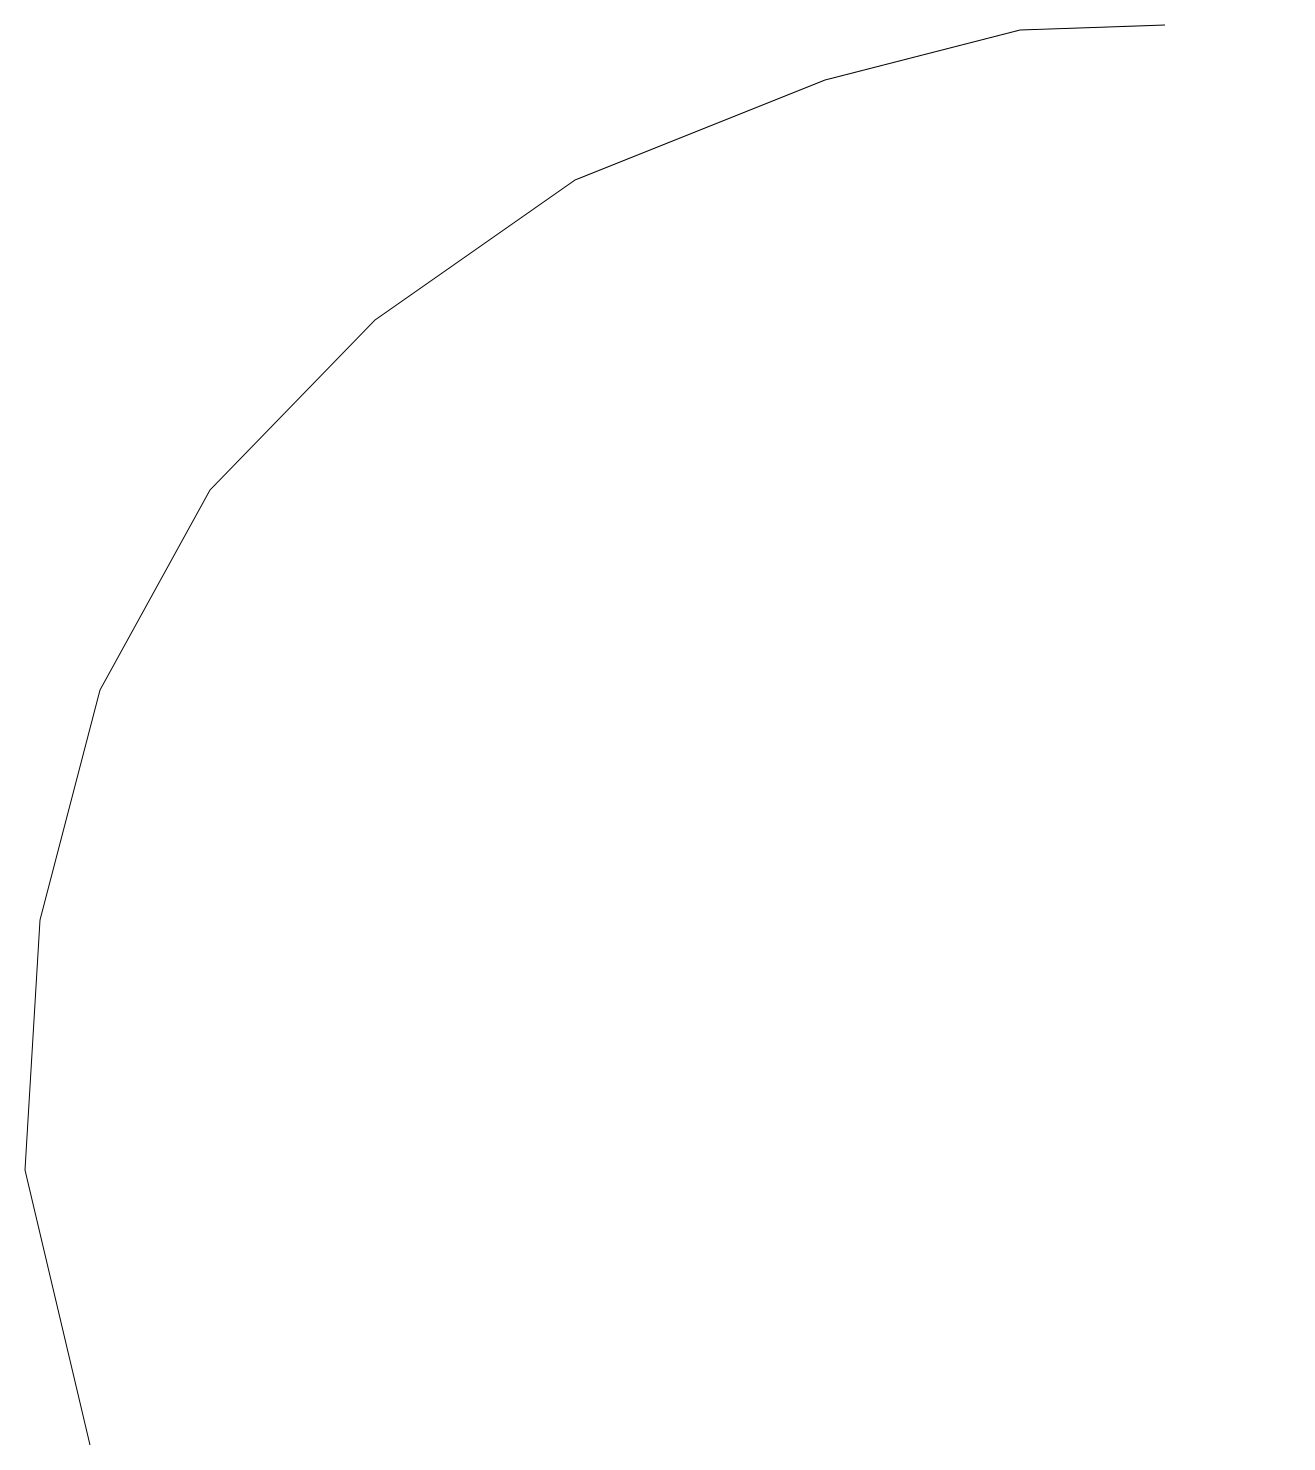

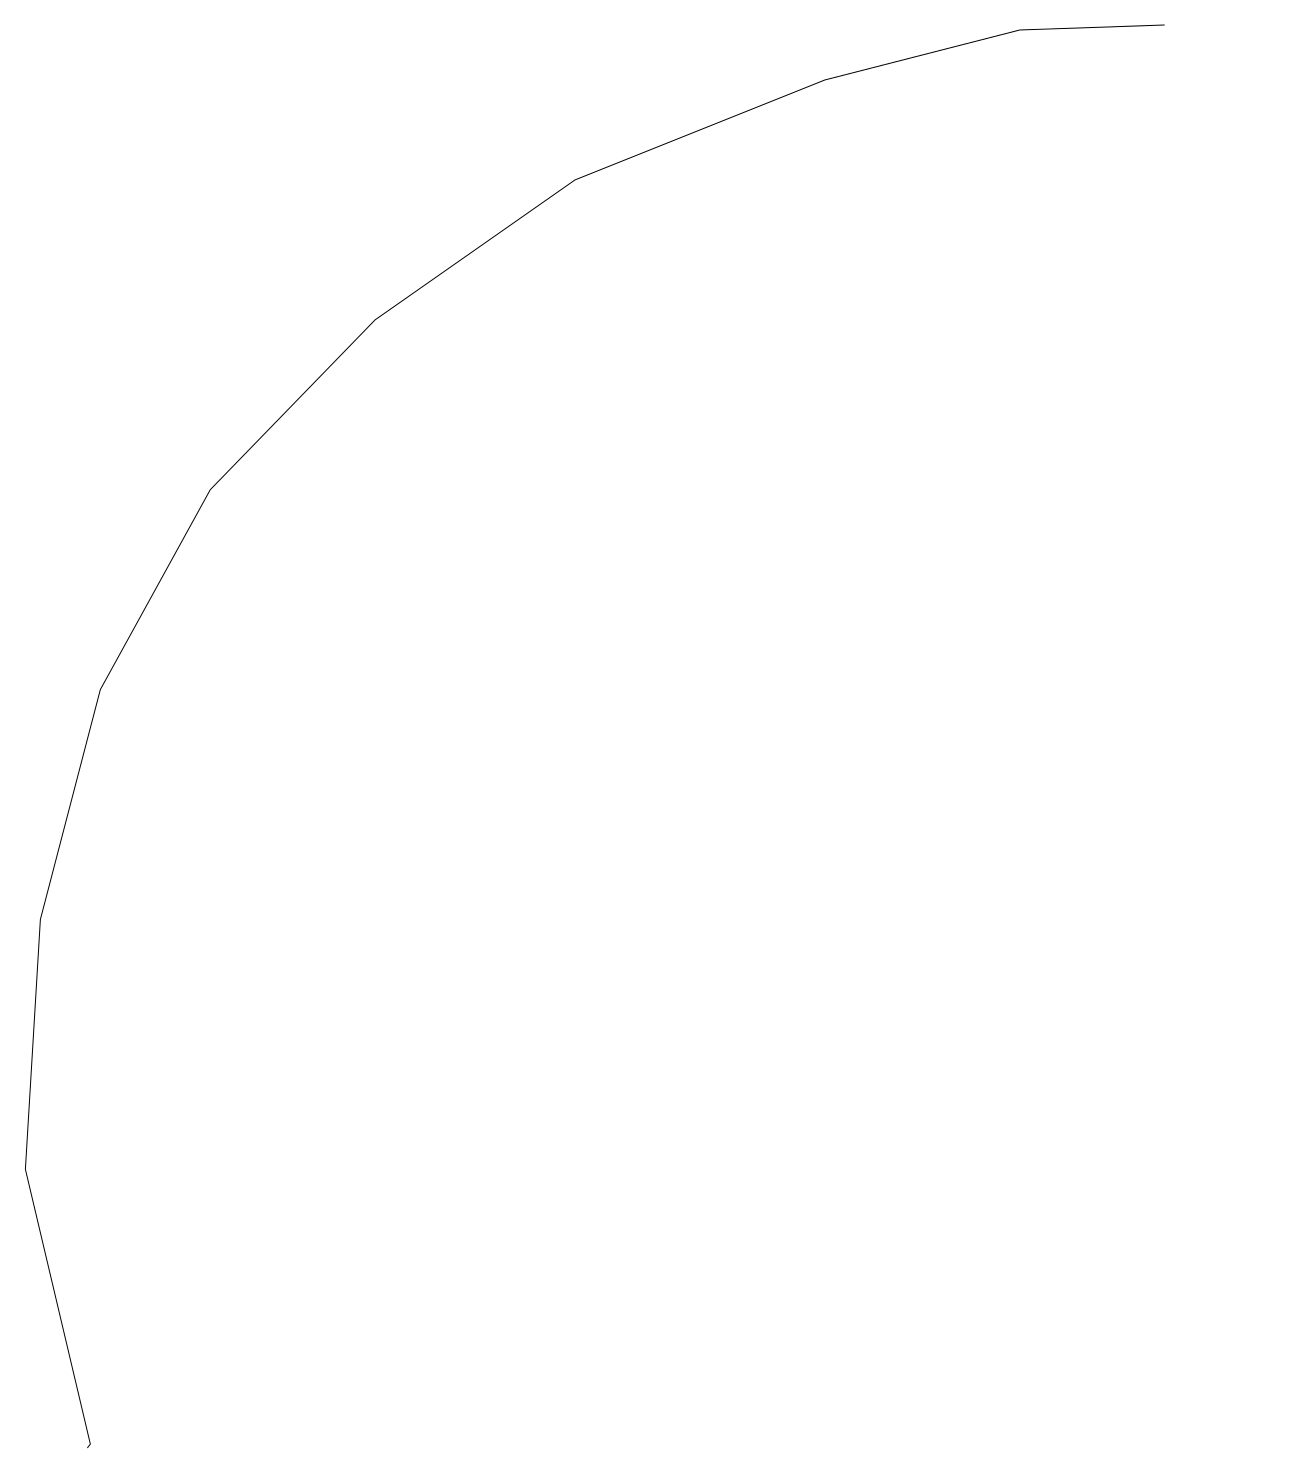

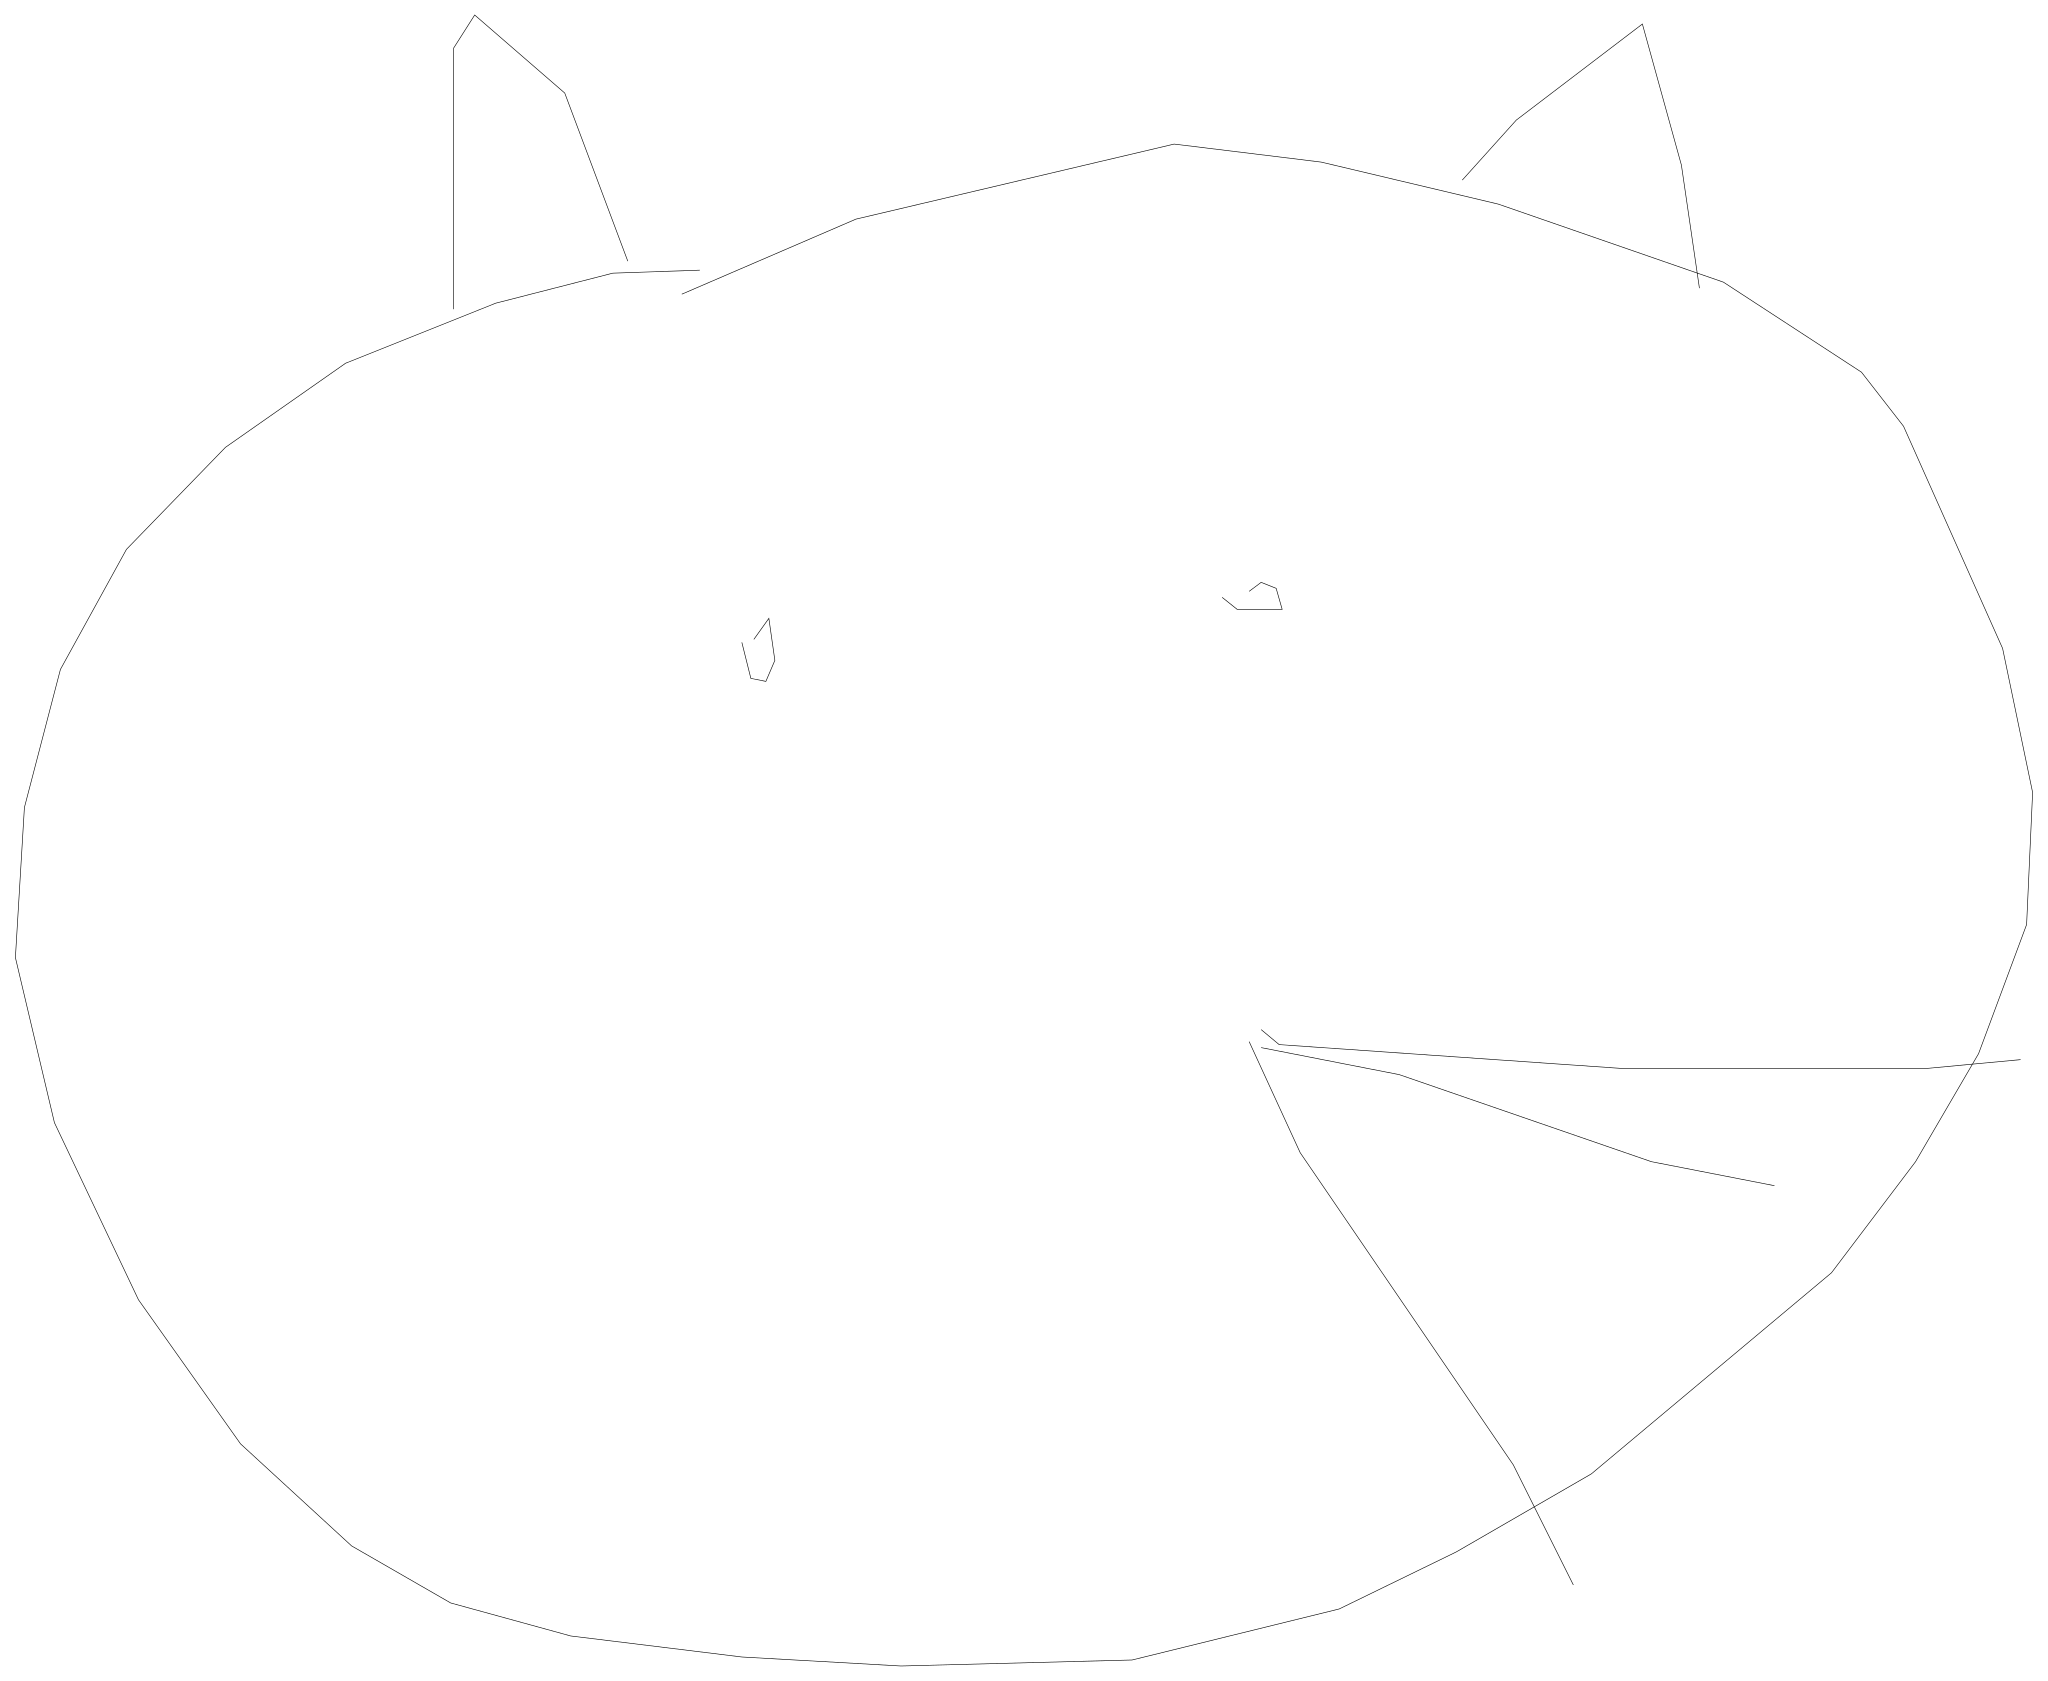

In [8]:
from utils import draw_strokes

@torch.inference_mode()
def generate(model, input_seq):
    prev = input_seq
    
    i = 0
    while i < 60:
        offset, state = model.forward(prev)
        indices = torch.argmax(state, dim=-1)
        one_hot = torch.nn.functional.one_hot(indices, 3)
        pred = torch.cat((offset, one_hot), dim=-1)
        next_seg = pred[:, -1:, :]
        prev = torch.cat((prev, next_seg), dim=1)
        i += 1
    
    return prev

strokes = train_dataset[10][0]
i = (strokes[:10]).unsqueeze(0)

output_pred = generate(model, i.to("cuda")).cpu().numpy()[0]
output_actual = strokes[:70].numpy()
draw_strokes(i[0], svg_filename='./input.svg')
draw_strokes(output_pred, svg_filename='./sample.svg')
draw_strokes(output_actual, svg_filename='./actual.svg')